# Diagnosis Cross-Prediction

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [16]:
from os.path import join
from common.data import get_data
from common.paths import BIOBANK_LABELS

adhd_group_one = join(BIOBANK_LABELS, 'Subjects_with_WISC (adhd 1).csv')
X_adhd_one, Y_adhd_one, demographics, population = get_data(5, adhd_group_one)

adhd_group_two = join(BIOBANK_LABELS, 'Subjects_with_WISC (adhd 2).csv')
X_adhd_two, Y_adhd_two, demographics, population = get_data(5, adhd_group_two)

healthy = join(BIOBANK_LABELS, 'Subjects_with_WISC (healthy).csv')
X_healthy, Y_healthy, demographics, population = get_data(5, healthy)

print(f'X_adhd_one: {X_adhd_one.shape} | X_adhd_two: {X_adhd_two.shape} | X_healthy: {X_healthy.shape}')

X_adhd_one: (106, 34716) | X_adhd_two: (106, 34716) | X_healthy: (106, 34716)


In [3]:
from common.scoring import pls_scorer, ridge_scorer
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [17]:
age_group = 'all'
selected_target = "WISC_FSIQ"
y_adhd_one = Y_adhd_one[selected_target]
y_adhd_two = Y_adhd_two[selected_target]
y_healthy = Y_healthy[selected_target]

print(f'{selected_target}: {y_adhd_one.shape}, {y_adhd_two.shape}, {y_healthy.shape}')

WISC_FSIQ: (106,), (106,), (106,)


In [32]:
X = X_healthy
y = y_healthy
X_out_group_one = X_adhd_one
y_out_group_one = y_adhd_one
X_out_group_two = X_adhd_two
y_out_group_two = y_adhd_two

In [23]:
X = X_adhd_one
y = y_adhd_one
X_out_group_one = X_healthy
y_out_group_one = y_healthy
X_out_group_two = X_adhd_two
y_out_group_two = y_adhd_two

In [27]:
X = X_adhd_two
y = y_adhd_two
X_out_group_one = X_adhd_one
y_out_group_one = y_adhd_one
X_out_group_two = X_healthy
y_out_group_two = y_healthy

### Set up the model pipeline, metrics, and cross-validation approach

In [19]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10)
n_perm = 3000

In [33]:
%%time

estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 55000, 5000)], 
                                        scoring=ridge_scorer, cv=rkf)]
pipe = make_pipeline(*estimators)
pipe.fit(X, y)
ridge_cv = pipe['ridgecv']
best_alpha = ridge_cv.alpha_

print(f'Target: {selected_target} | Alpha: {best_alpha} | Score: {ridge_cv.best_score_:.2f}')

Target: WISC_FSIQ | Alpha: 5000 | Score: 0.08
CPU times: user 1min 53s, sys: 1.79 s, total: 1min 55s
Wall time: 11.6 s


### Run cross-validation

In [34]:
%%time
train_scores, test_scores, out_group_one, out_group_two = [], [], [], []
coefs, inters = [], []

for train_index, test_index in rkf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
#     pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    train_scores.append(regression_scorer(pipe, X_train, y_train))
    test_scores.append(regression_scorer(pipe, X_test, y_test))
    out_group_one.append(regression_scorer(pipe, X_out_group_one, y_out_group_one))
    out_group_two.append(regression_scorer(pipe, X_out_group_two, y_out_group_two))

    coefs.append(pipe['ridge'].coef_)
    inters.append(pipe['ridge'].intercept_)

avg_coef = np.mean(coefs, axis=0)
avg_inte = np.mean(inters, axis=0)

print(f'{population}_{selected_target}_{age_group}')
for metric in [train_scores, test_scores, out_group_one, out_group_two]:
    print(f'{np.mean(metric):.2f}')

healthy_WISC_FSIQ_all
1.00
0.04
0.33
0.28
CPU times: user 1min 41s, sys: 1.6 s, total: 1min 42s
Wall time: 10.3 s


In [26]:
adhd_one_coefs = coefs.copy()

In [30]:
adhd_two_coefs = coefs.copy()

In [35]:
healthy_coefs = coefs.copy()

Text(0.5, 1.0, 'Cross Validation Results ( -> )')

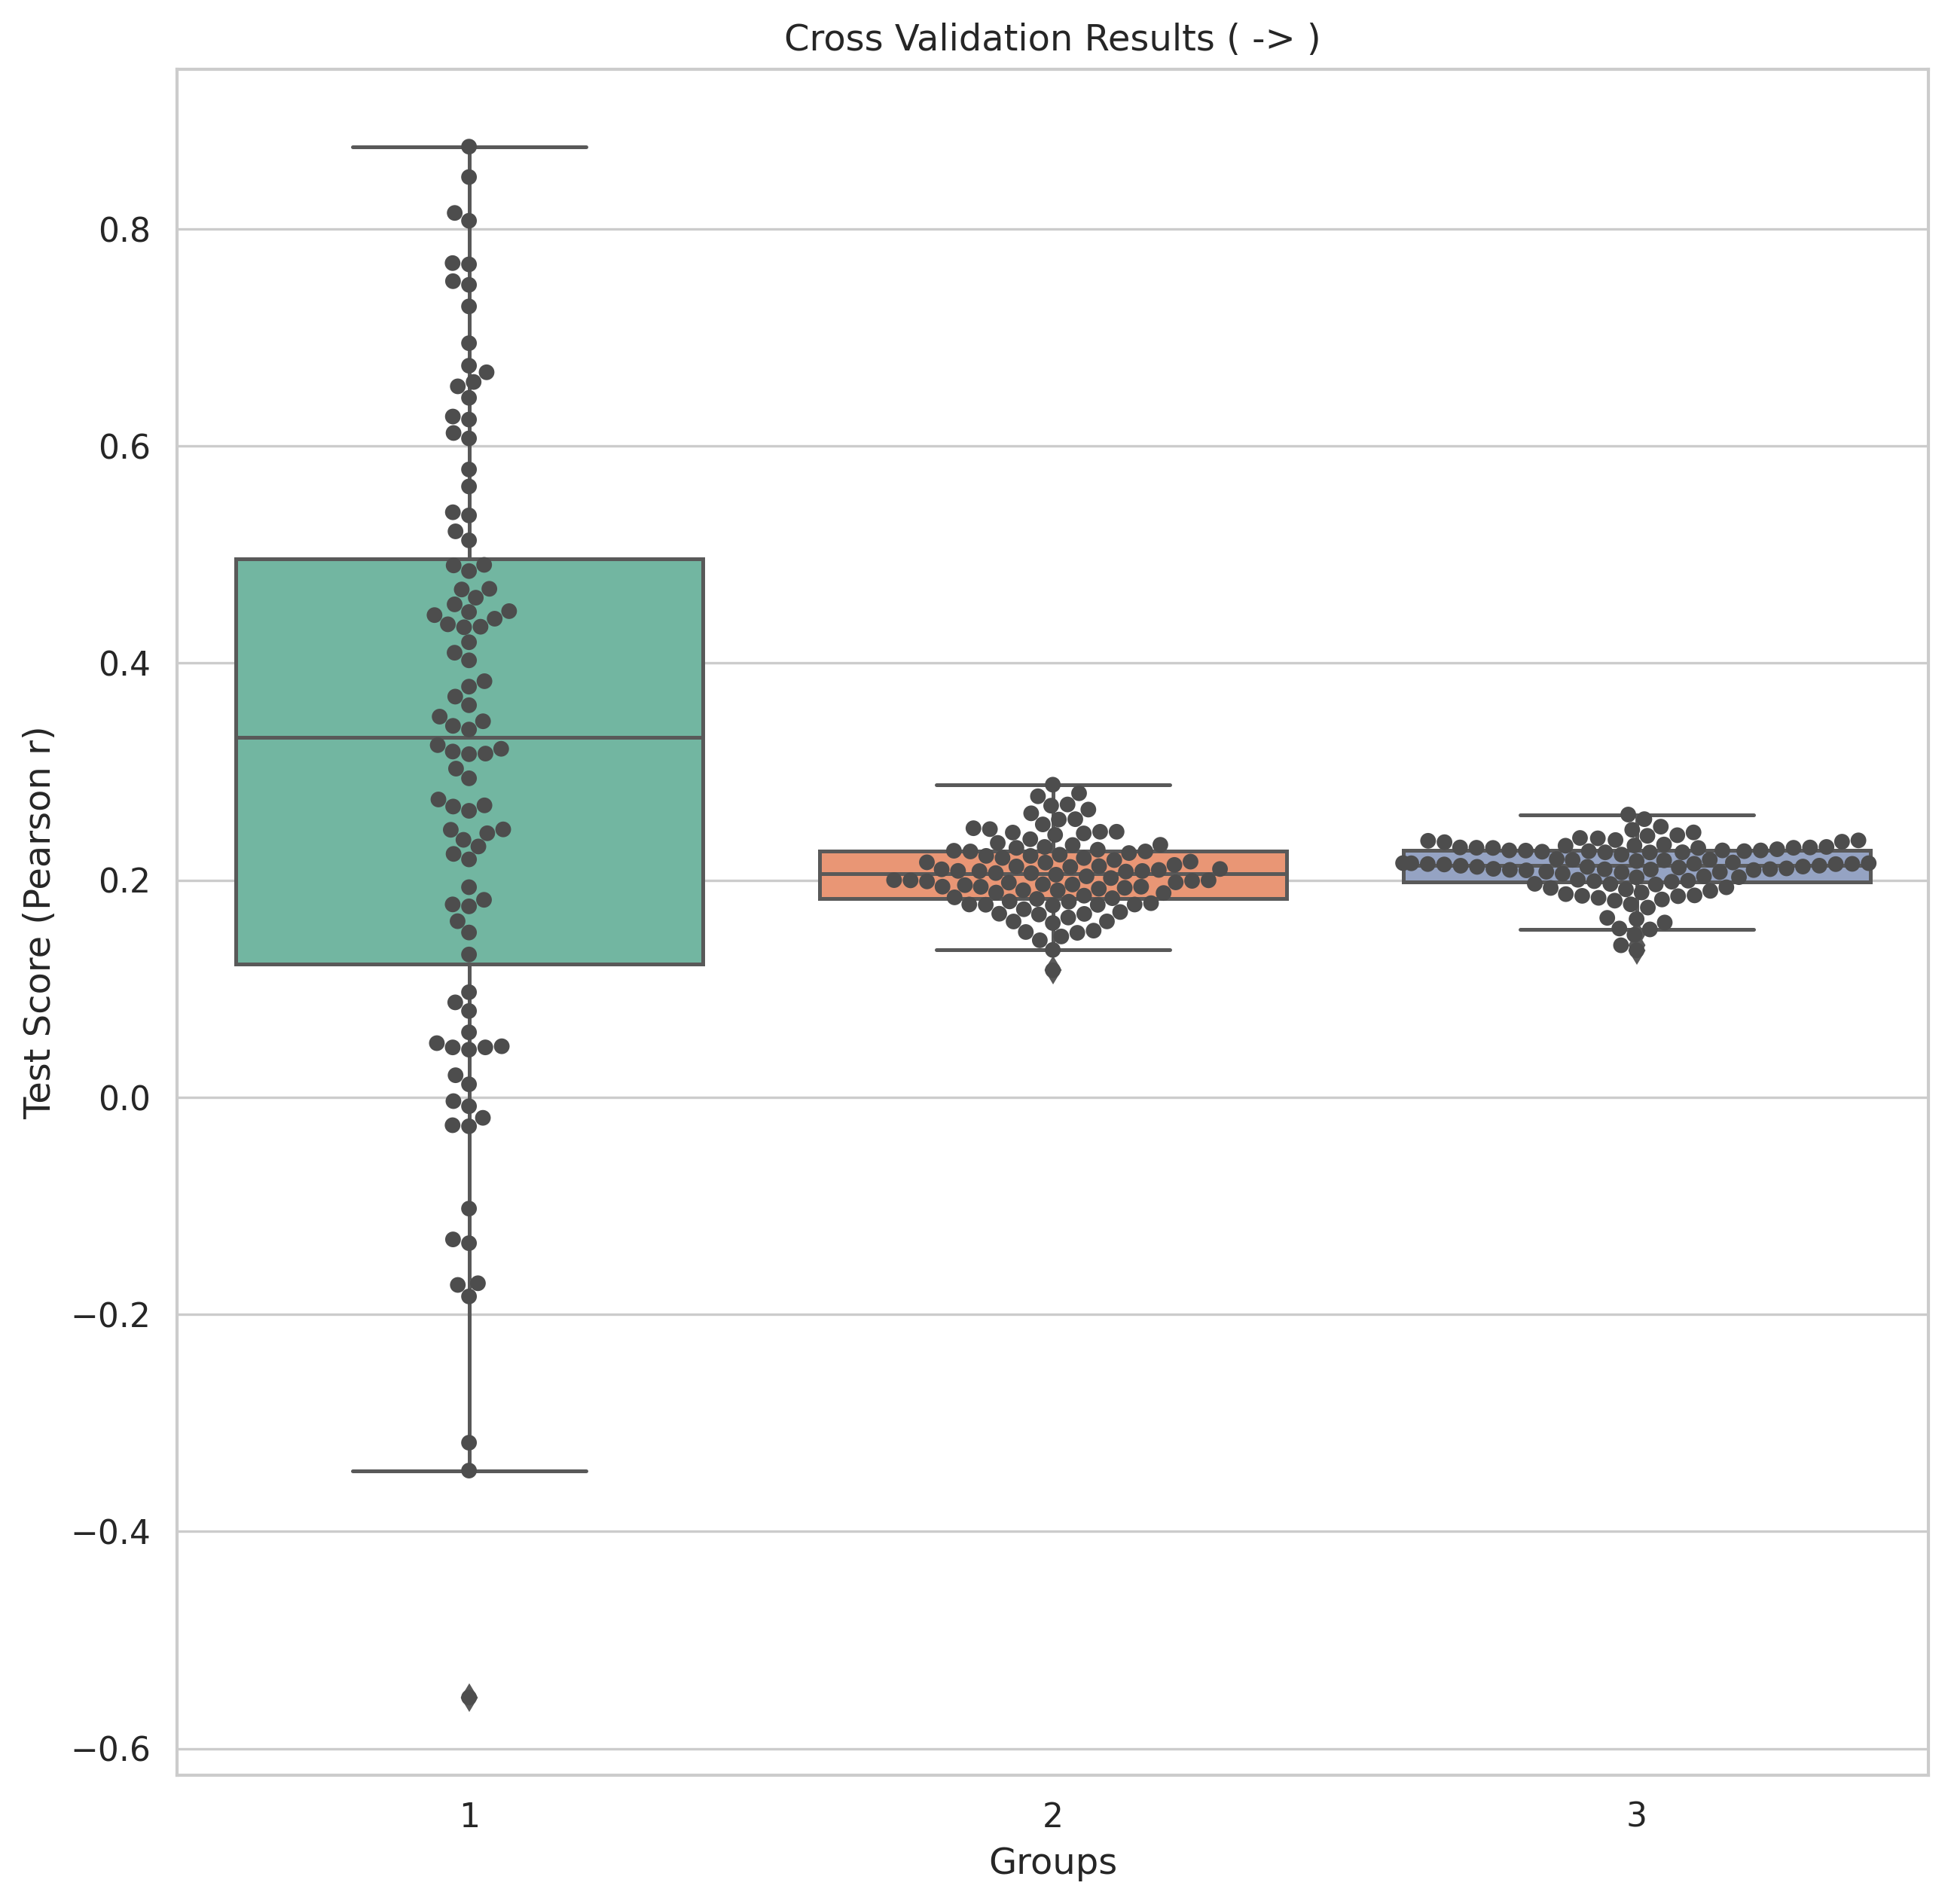

In [31]:
results = pd.DataFrame({'1': test_scores, '2': out_group_one, '3': out_group_two})

ax = sns.boxplot(data=results, palette="Set2")
ax = sns.swarmplot(data=results, color="0.3")
ax.set_ylabel('Test Score (Pearson r)')
ax.set_xlabel('Groups')
ax.set_title('Cross Validation Results ( -> )')

### Transfer model weights

#### ICC

In [36]:
%%time
import pingouin as pg

group_one = pd.DataFrame(adhd_one_coefs)
group_one['group'] = 'g1'

group_two = pd.DataFrame(healthy_coefs)
group_two['group'] = 'g2'

group_one_two = pd.concat([group_one, group_two])
icc_data = pd.melt(group_one_two, id_vars='group', var_name='connection', 
                   value_name='weight', ignore_index=False)
# display(icc_data)

icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='group', ratings='weight').round(3)
icc.set_index("Type")

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


CPU times: user 35.8 s, sys: 443 ms, total: 36.2 s
Wall time: 34.7 s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.092,1.203,34715,34716,0.0,"[0.08, 0.1]"
ICC2,Single random raters,0.093,1.206,34715,34715,0.0,"[0.08, 0.1]"
ICC3,Single fixed raters,0.094,1.206,34715,34715,0.0,"[0.08, 0.1]"
ICC1k,Average raters absolute,0.169,1.203,34715,34716,0.0,"[0.15, 0.19]"
ICC2k,Average random raters,0.171,1.206,34715,34715,0.0,"[0.15, 0.19]"
ICC3k,Average fixed raters,0.171,1.206,34715,34715,0.0,"[0.15, 0.19]"
